In [1]:
import numpy as np
import sys
sys.path.insert(0, '../')
import copy
import os
from rotm2euler import *
from test_utils import *
from experiment_utils import *

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.pyplot import cm
from matplotlib import collections as mc
import pdb

## Input Data

In [2]:
### get pair id
pair_path = '/viscompfs/users/sawang/ScanNet/pair_list.txt'
f = open(pair_path)
lines = f.readlines()
lines[9995:10000]

['scene0001_01 1190-1200-1213 \n',
 'scene0001_01 1190-1201-1211 \n',
 'scene0001_01 1190-1202-1212 \n',
 'scene0001_01 1190-1203-1217 \n',
 'scene0001_01 1192-1204-1217 \n']

In [3]:
def input_data(tgt_id, src0_id, src1_id, dataset_dir, gt_dir, H, W):
    data_dict = dict()
    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(tgt_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ori_H, ori_W, _ = image.shape
    image = cv2.resize(image, (320, 240))
    data_dict['tgt_RGB'] = image

    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(src0_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240))
    data_dict['src0_RGB'] = image

    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(src1_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240))
    data_dict['src1_RGB'] = image

    image = cv2.imread(os.path.join(gt_dir, scene, 'depth_interp', str(tgt_id) + ".png"), cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (320, 240))
    data_dict['depth'] = image / 1000

    #image = cv2.imread(os.path.join('/viscompfs/users/sawang/testnormal_2.png'), cv2.IMREAD_UNCHANGED)
    #image = cv2.resize(image, (320, 240)) / 255
    #image = unplot_normal(image)
    #data_dict['tgt_norm'] = image
    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_2.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['tgt_norm'] = image

    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_1.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['src0_norm'] = image

    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_3.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['src1_norm'] = image

    mat = np.loadtxt(os.path.join(dataset_dir, scene, 'intrinsic', 'intrinsic_color.txt'))
    scale_x, scale_y = H / ori_H, W / ori_W
    mat[0, 0], mat[0, 2] = mat[0, 0] * scale_x, mat[0, 2] * scale_x
    mat[1, 1], mat[1, 2] = mat[1, 1] * scale_y, mat[1, 2] * scale_y
    data_dict['K'] = mat
    print("intrinsic: \n", mat)

    mat = np.loadtxt(os.path.join(dataset_dir, scene, 'intrinsic', 'intrinsic_depth.txt'))
    scale_x, scale_y = H / ori_H, W / ori_W
    mat[0, 0], mat[0, 2] = mat[0, 0] * scale_x, mat[0, 2] * scale_x
    mat[1, 1], mat[1, 2] = mat[1, 1] * scale_y, mat[1, 2] * scale_y
    data_dict['K_d'] = mat
    print("intrinsic (depth): \n", mat)

    pose_path = '/viscompfs/users/sawang/ScanNet/data_pose/' + scene + '.txt'
    f = open(pose_path)
    pose_all = f.readlines()

    for p in pose_all:
        char = p.split(" ")
        if char[0] == str(tgt_id) and char[1] == str(src1_id):
            data_dict['pose1'] = untransform(np.array([float(c.replace(",", "")) for c in char[2:]]))
            print("pose1: \n", data_dict['pose1'])
        elif char[0] == str(src0_id) and char[1] == str(tgt_id):
            tmp = np.array([float(c.replace(",", "")) for c in char[2:]])
            tmp = untransform(tmp)
            pose_inv = inversePose(tmp)
            data_dict['pose0'] = pose_inv
            print("pose0: \n", data_dict['pose0'])
    return data_dict

In [4]:
tgt_id, src0_id, src1_id = 1200, 1190, 1213
H, W = 240, 320
scene = 'scene0001_01'
dataset_dir = '/viscompfs/users/sawang/ScanNet/data/scans/'
gt_dir = '/viscompfs/users/sawang/ScanNet/data_gt/'

data = input_data(tgt_id, src0_id, src1_id, dataset_dir, gt_dir, H, W)

intrinsic: 
 [[290.12925322   0.         160.59917355   0.        ]
 [  0.         288.93530568 119.44444444   0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]
intrinsic (depth): 
 [[143.27370372   0.          79.21487603   0.        ]
 [  0.         142.6841      59.13580247   0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]
pose0: 
 [[ 0.99720706 -0.01383514 -0.07339395  0.02787871]
 [ 0.00892915  0.99772935 -0.06675639 -0.09059185]
 [ 0.07415088  0.06591459  0.99506629  0.13103101]
 [ 0.          0.          0.          1.        ]]
pose1: 
 [[ 0.99900703 -0.03768448 -0.0237662   0.050552  ]
 [ 0.03849179  0.99866389  0.03447915  0.089673  ]
 [ 0.02243512 -0.03535972  0.99912279 -0.182378  ]
 [ 0.          0.          0.          1.        ]]


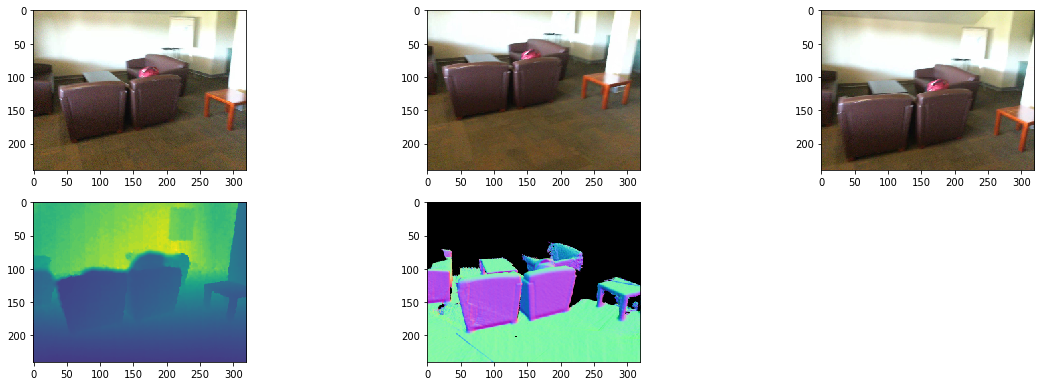

In [5]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(3, 3, 1)
ax.imshow(data['tgt_RGB'])
ax = fig.add_subplot(3, 3, 2)
ax.imshow(data['src0_RGB'])
ax = fig.add_subplot(3, 3, 3)
ax.imshow(data['src1_RGB'])
ax = fig.add_subplot(3, 3, 4)
ax.imshow(data['depth'])
ax = fig.add_subplot(3, 3, 5)
ax.imshow(plot_normal(data['tgt_norm']))
plt.show()

### Choose target location

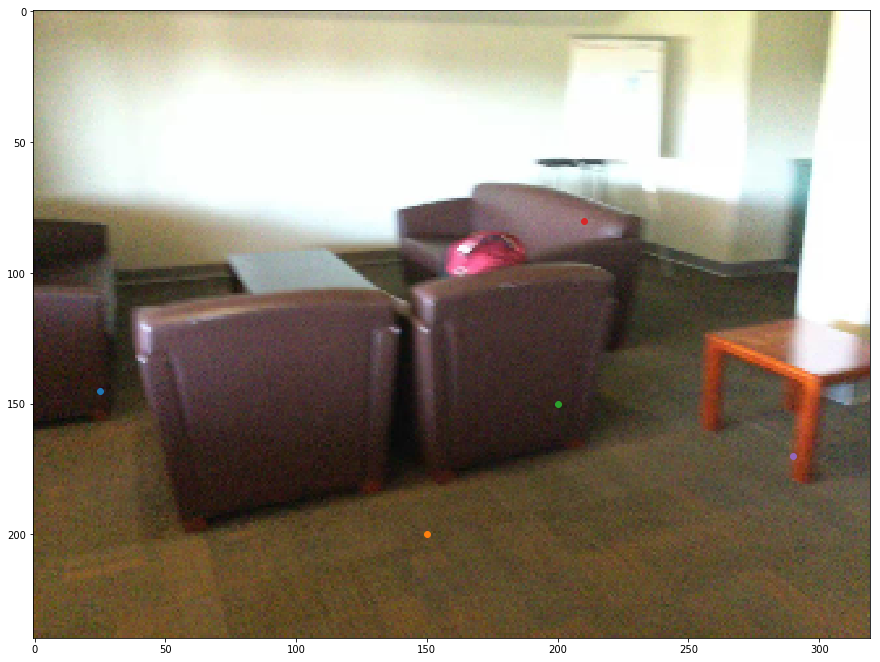

In [6]:
loc = np.array([[25, 150, 200, 210, 290],
                [145, 200,150,  80, 170]])


plt.figure(figsize=(15, 15))
plt.imshow(data['tgt_RGB'])
for [[x], [y]] in np.split(loc, loc.shape[1], axis=1):
    plt.scatter(x, y)
plt.show()

### Functions

In [7]:
def get_meshgrid(w, h, x_ctr, y_ctr):
    x_upper_left = x_ctr - w//2
    y_upper_left = y_ctr - h//2
    
    x = np.arange(0, w)
    y = np.arange(0 ,h)
    xv, yv = np.meshgrid(x, y)
    xv = xv.astype(np.float)
    yv = yv.astype(np.float)
    xv += x_upper_left
    yv += y_upper_left
    return xv, yv

def get_tgt_patch(pt, tgt, patch_size):
    x, y = pt[0, 0], pt[1, 0]
    ofs = (patch_size - 1) // 2
    return tgt[y-ofs:y+ofs+1, x-ofs:x+ofs+1]

def warp_patch(pt, depth, K, rel_pose, src, patch_size):
    ps_ctr = warp_location(pt, K, rel_pose, depth)
    xv, yv = get_meshgrid(patch_size, patch_size, ps_ctr[0, 0], ps_ctr[1, 0]) # x-coord, y-coord
    xv = xv.flatten()
    yv = yv.flatten()
    ps = np.vstack([xv, yv]) # [2, patch_size**2]
    
    patch_img = np.zeros([patch_size, patch_size, 3])
    for x in range(patch_size):
        for y in range(patch_size):
            i = y * patch_size + x
            patch_img[y, x] = bilinear_pt(ps[:, i, np.newaxis], src)
    return ps, patch_img

def plot_inv_curve(loc, loss_criterion,
                   tgt, src,
                   rel_pose, intrinsics, dmap):
    """Plot intensity difference versus inverse depth"""
    s = 3 # rectangle size
    psize = [1, 3, 5, 7, 9, 11]
    colors = cm.rainbow(np.linspace(0, 1, loc.shape[1]))
    colors_p = cm.rainbow(np.linspace(0, 1, len(psize)))
    
    if type(tgt[0, 0, 0]) == np.uint8:
        tgt = tgt/255
    if type(src[0, 0, 0]) == np.uint8:
        src = src/255
    
    # prepare figure
    fig = plt.figure(figsize=(20, 10))
    ax_tgt = fig.add_subplot(131)
    ax_src = fig.add_subplot(132)
    ax_src_big = fig.add_subplot(133)
    ax_tgt.imshow(tgt)
    ax_src.imshow(src)
    ax_src_big.imshow(src)
    ax_tgt.set_title('Target')
    ax_src.set_title('Source')
    ax_src_big.set_title('Source Enlarged')
    ax_src.set_ylim(bottom=H, top=0)

    # warp provided coordinates
    inv_depth_values = np.arange(0.01, 1.01, 0.001)
    locations = np.split(loc, loc.shape[1], axis=1)

    # will contain tuple of ('pt', 'ps', 'It', 'Is', 'inv_depth', 'diff')
    result = defaultdict(list)
    r = namedtuple('r', 'pt ps It Is inv_depth diff')
    
    for i, (pt, c) in enumerate(zip(locations, colors)):
        print('{}/{} locations'.format(i+1, loc.shape[1]))
        for patch_size in psize:
            n_mid = (patch_size**2 - 1)//2
            tgt_patch = get_tgt_patch(pt, tgt, patch_size) # single-pixel
            for inv_d in inv_depth_values:
                # warp
                d = 1/inv_d
                if patch_size == 1:
                    ps = warp_location(pt, intrinsics, rel_pose, d)
                    src_patch = bilinear_pt(ps[:, 0, np.newaxis], src) # single-pixel
                    diff = np.mean(np.abs(tgt_patch - src_patch))
                else:
                    src_coords, src_patch = warp_patch(pt, d, intrinsics, rel_pose, src, patch_size)
                    ps = src_coords[:, n_mid, np.newaxis]
                    diff = loss_criterion(tgt_patch, src_patch)
                tmp = r(pt=pt, ps=ps, It=tgt_patch, Is=src_patch, inv_depth=inv_d, diff=diff)
                result[(i, patch_size)].append(tmp)

    # plot RGB images for comparison
    print('Generating plots')
    for i, (pt, c) in enumerate(zip(locations, colors)):
        # plot rectangles on target image
        rect = patches.Rectangle((pt[0, 0]-s//2, pt[1, 0]-s//2), s, s,
                                 linewidth=1,edgecolor=c,facecolor='none')
        ax_tgt.add_patch(rect)

        # plot ground-truth correspondence on source image
        gt_corr = warp_location(pt, intrinsics, rel_pose, dmap[tuple(pt)[::-1]])
        rect2 = patches.Rectangle((gt_corr[0, 0]-s//2, gt_corr[1, 0]-s//2), s, s,
                                   linewidth=1,edgecolor=c,facecolor='none')
        rect2_ = patches.Rectangle((gt_corr[0, 0]-s//2, gt_corr[1, 0]-s//2), s, s,
                                   linewidth=1,edgecolor=c,facecolor='none')
        ax_src.add_patch(rect2)
        ax_src_big.add_patch(rect2_)
        ax_src_big.set_xlim([gt_corr[0, 0]-10, gt_corr[0, 0]+10])
        ax_src_big.set_ylim([gt_corr[1, 0]-10, gt_corr[1, 0]+10])

        # plot lowest photometric loss on source image
        for patch_size, c_p in zip(psize, colors_p):
            diffs = [x.diff for x in result[(i, patch_size)]]
            lowest_idx = np.argmin(diffs)
            lowest_ps = result[(i, patch_size)][lowest_idx].ps
            circle = patches.Circle((lowest_ps[0, 0], lowest_ps[1, 0]), radius=s//2,
                                     linewidth=1,edgecolor=c_p,facecolor='none')
            circle_ = patches.Circle((lowest_ps[0, 0], lowest_ps[1, 0]), radius=s//2,
                                     linewidth=1,edgecolor=c_p,facecolor='none')
            ax_src.add_patch(circle)
            ax_src_big.add_patch(circle_)
            #plt.text(lowest_ps[0, 0], lowest_ps[1, 0]-5, '{}'.format(patch_size))
            
    plt.show()

    # plot error curve
    for i in range(loc.shape[1]):
        gt_depth = dmap[tuple(locations[i])[::-1]]
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        ax.axvline(x=1/gt_depth, c='k', linewidth=3)
        
        print(locations[i].flatten(), 'ground truth depth', ':',gt_depth[0])
        
        p_min, err_min = -1, 1e6
        for patch_size, c in zip(psize, colors_p):
            diffs = [x.diff for x in result[(i, patch_size)]]
            lowest_idx = np.argmin(diffs)
            lowest_inv_depth = result[(i, patch_size)][lowest_idx].inv_depth
            ax.plot(inv_depth_values, diffs, c=c, label=patch_size)
            ax.axvline(lowest_inv_depth, c=c)
            print('p={} line depth w/ lowest error:{}'.format(patch_size, 1/lowest_inv_depth))
            
            # keep track of lowest error
            err = np.abs(gt_depth - 1/lowest_inv_depth)
            if err < err_min:
                p_min, err_min = patch_size, err
                
        print('The most accurate patch size: {}, abs error: {}'.format(p_min, err_min))    
        #ax.set_xlim([1/gt_depth[0]-0.2, 1/gt_depth[0]+0.2])
        ax.set_xlabel('Inverse Depth')
        ax.set_ylabel('Photometric Error')
        ax.legend()
        plt.show()

    plt.close('all')
    return result

1/1 locations
Generating plots


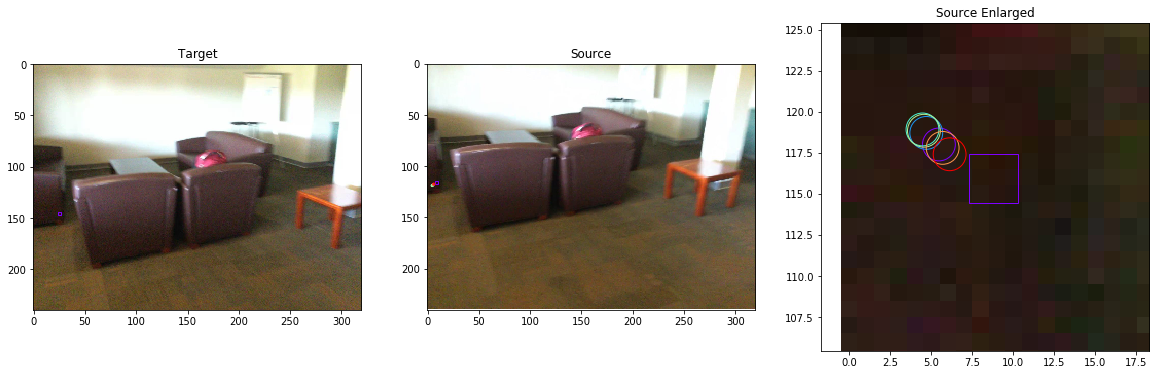

[ 25 145] ground truth depth : 2.889
p=1 line depth w/ lowest error:4.065040650406507
p=3 line depth w/ lowest error:4.566210045662104
p=5 line depth w/ lowest error:4.739336492890999
p=7 line depth w/ lowest error:4.672897196261686
p=9 line depth w/ lowest error:3.9370078740157513
p=11 line depth w/ lowest error:3.7174721189591104
The most accurate patch size: 11, abs error: [0.82847212]


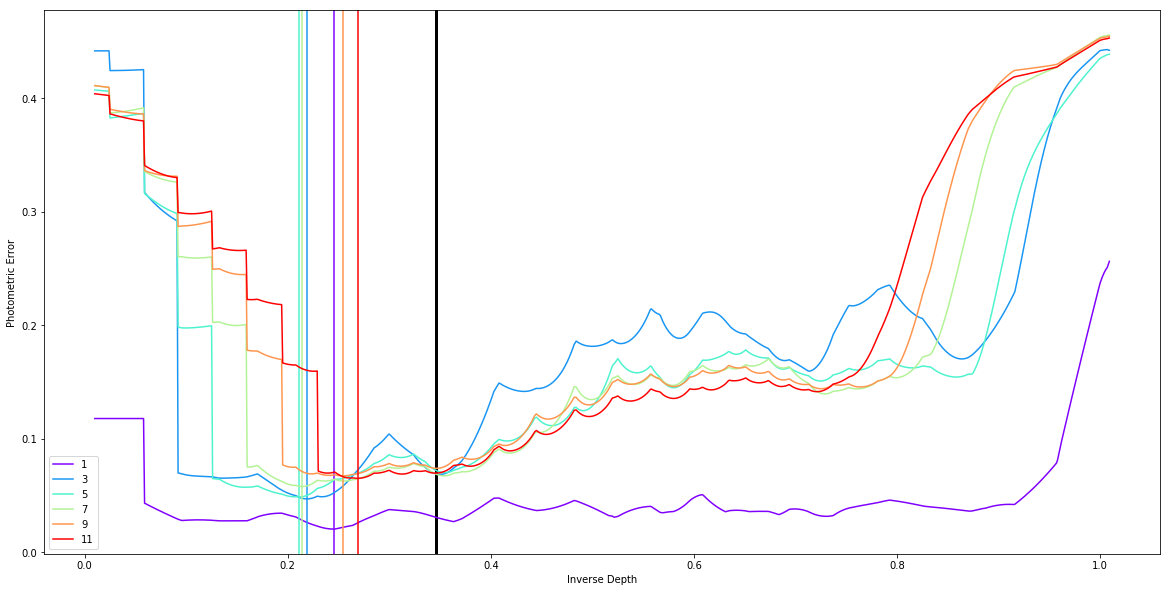

1/1 locations
Generating plots


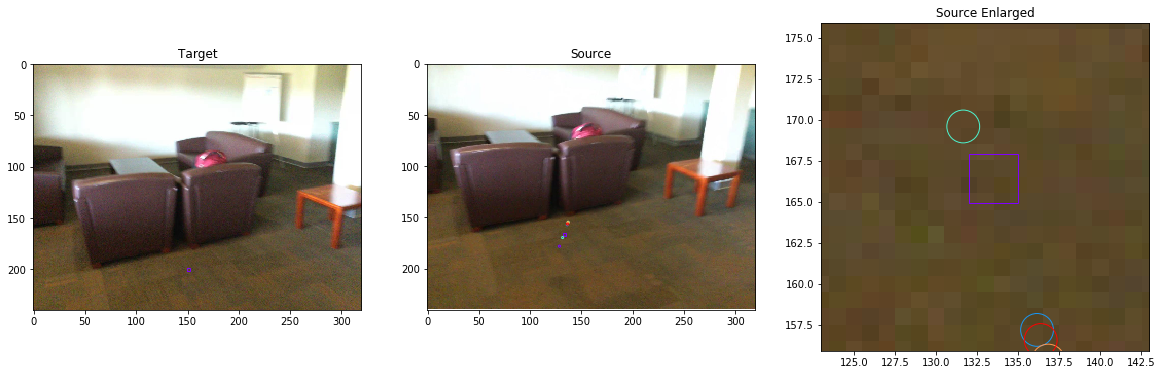

[150 200] ground truth depth : 2.301
p=1 line depth w/ lowest error:18.51851851851853
p=3 line depth w/ lowest error:1.3623978201634888
p=5 line depth w/ lowest error:3.1746031746031775
p=7 line depth w/ lowest error:1.2150668286755781
p=9 line depth w/ lowest error:1.2484394506866427
p=11 line depth w/ lowest error:1.322751322751324
The most accurate patch size: 5, abs error: [0.87360317]


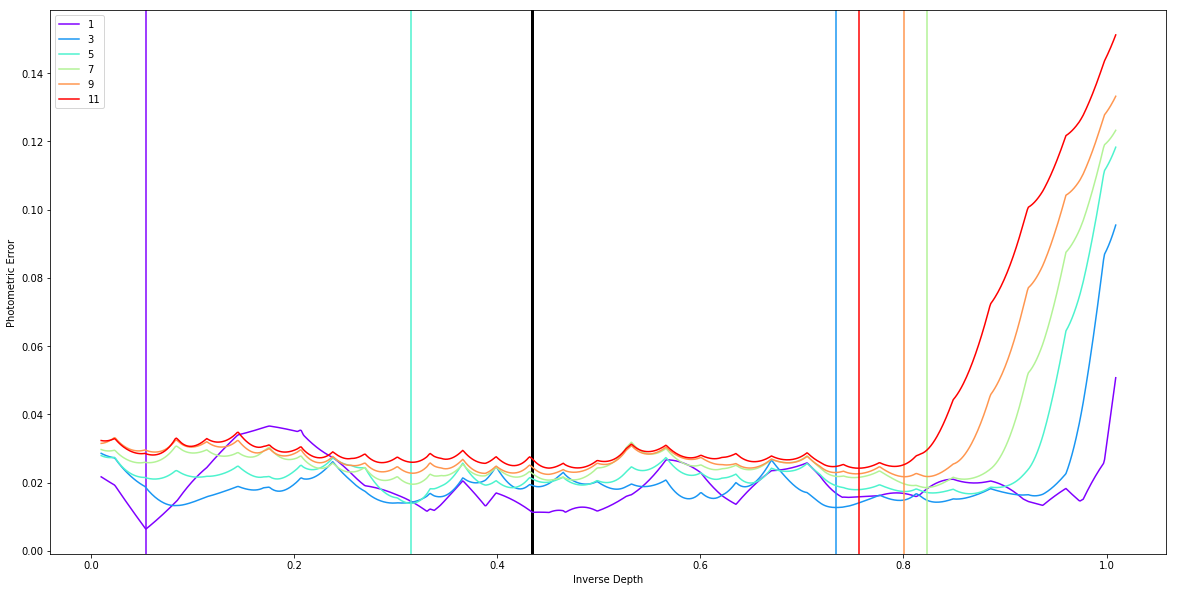

1/1 locations
Generating plots


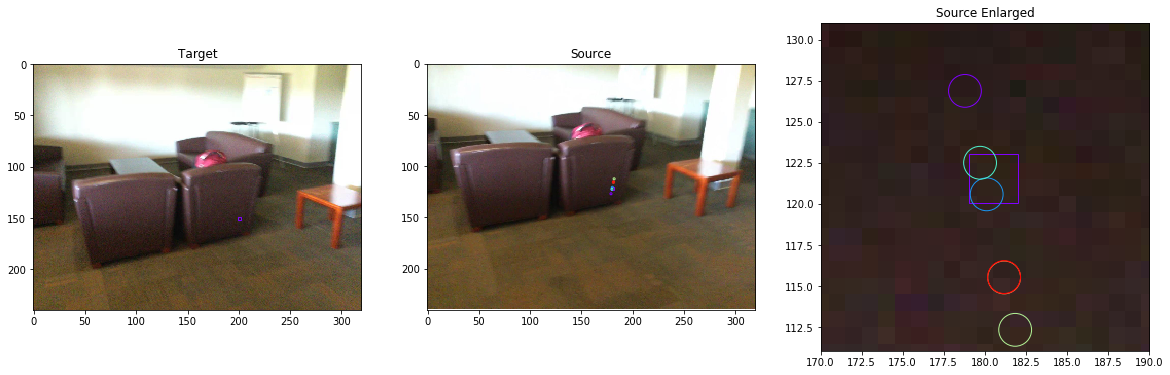

[200 150] ground truth depth : 2.658
p=1 line depth w/ lowest error:6.756756756756762
p=3 line depth w/ lowest error:2.531645569620255
p=5 line depth w/ lowest error:3.1446540880503173
p=7 line depth w/ lowest error:1.3458950201884263
p=9 line depth w/ lowest error:1.6528925619834722
p=11 line depth w/ lowest error:1.655629139072849
The most accurate patch size: 3, abs error: [0.12635443]


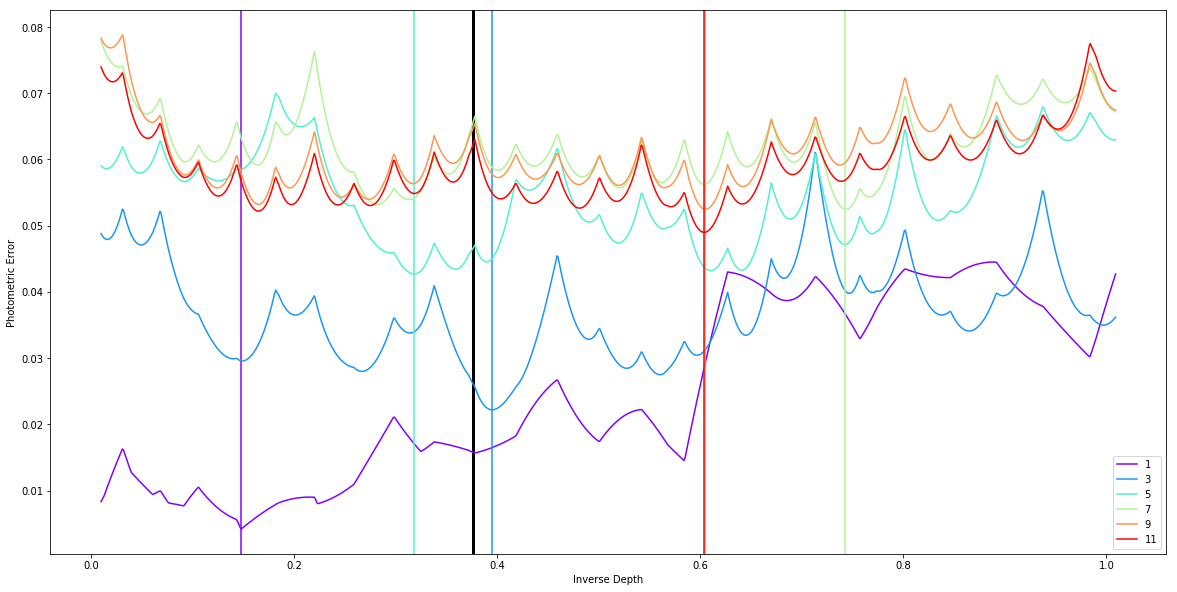

1/1 locations
Generating plots


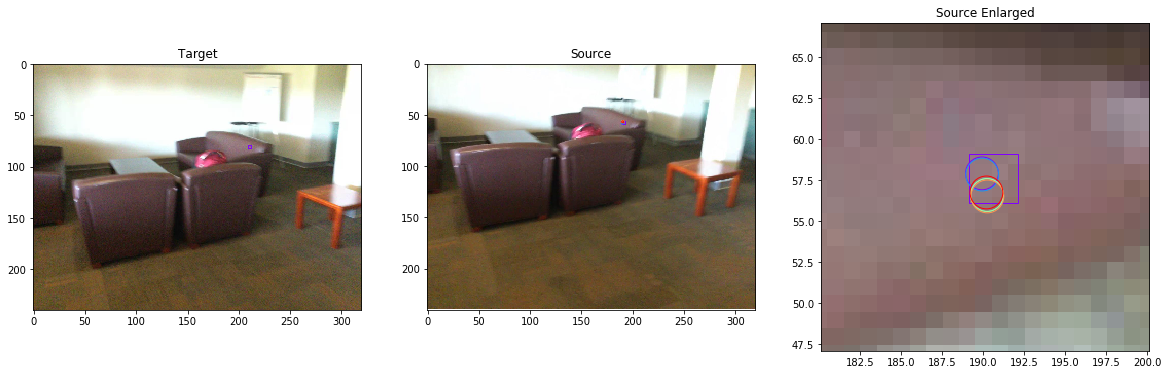

[210  80] ground truth depth : 4.446
p=1 line depth w/ lowest error:5.586592178770954
p=3 line depth w/ lowest error:5.464480874316944
p=5 line depth w/ lowest error:3.9370078740157513
p=7 line depth w/ lowest error:3.9370078740157513
p=9 line depth w/ lowest error:3.8610038610038644
p=11 line depth w/ lowest error:4.081632653061228
The most accurate patch size: 11, abs error: [0.36436735]


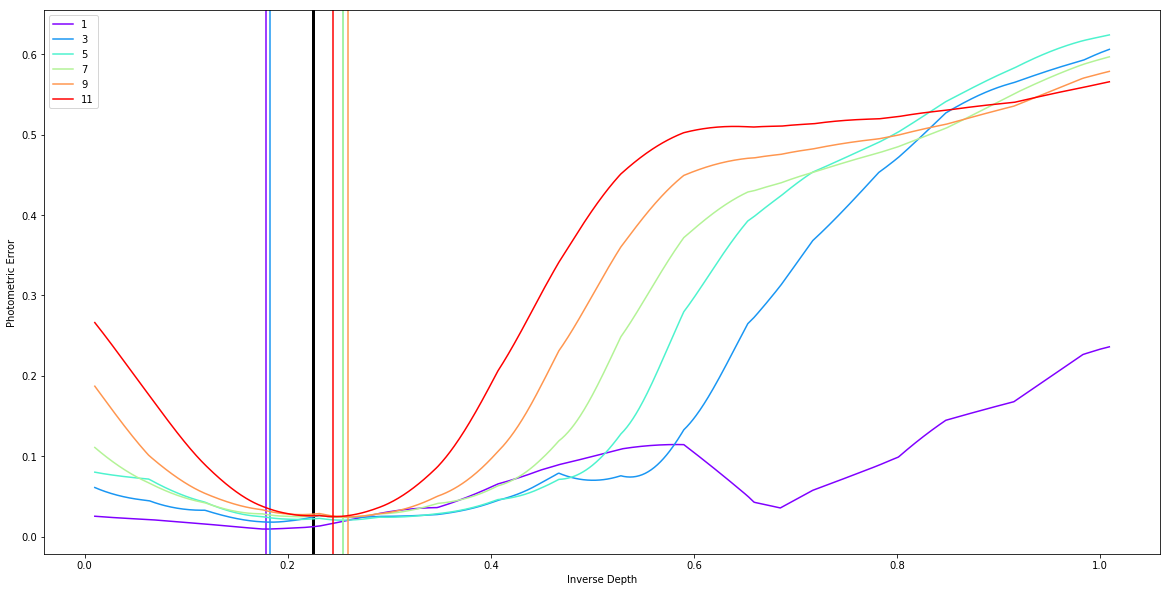

1/1 locations
Generating plots


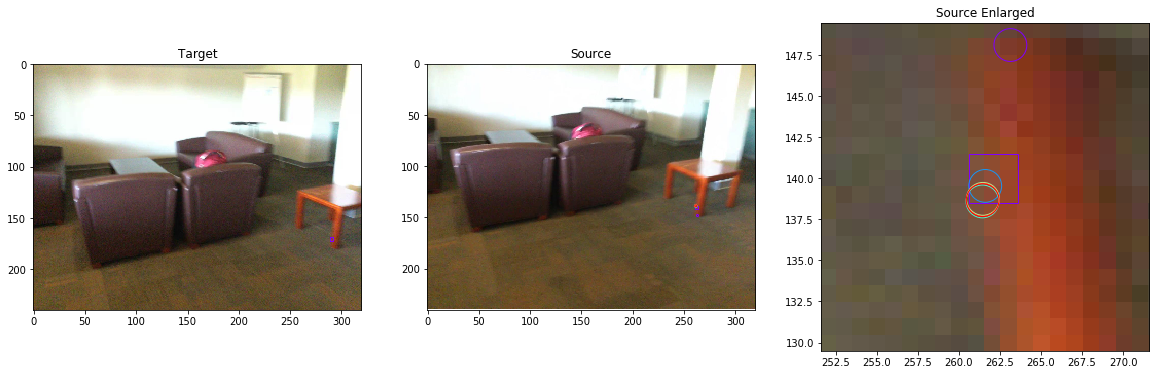

[290 170] ground truth depth : 2.514
p=1 line depth w/ lowest error:12.048192771084347
p=3 line depth w/ lowest error:2.5252525252525273
p=5 line depth w/ lowest error:2.3148148148148167
p=7 line depth w/ lowest error:2.3474178403755888
p=9 line depth w/ lowest error:2.336448598130843
p=11 line depth w/ lowest error:2.331002331002333
The most accurate patch size: 3, abs error: [0.01125253]


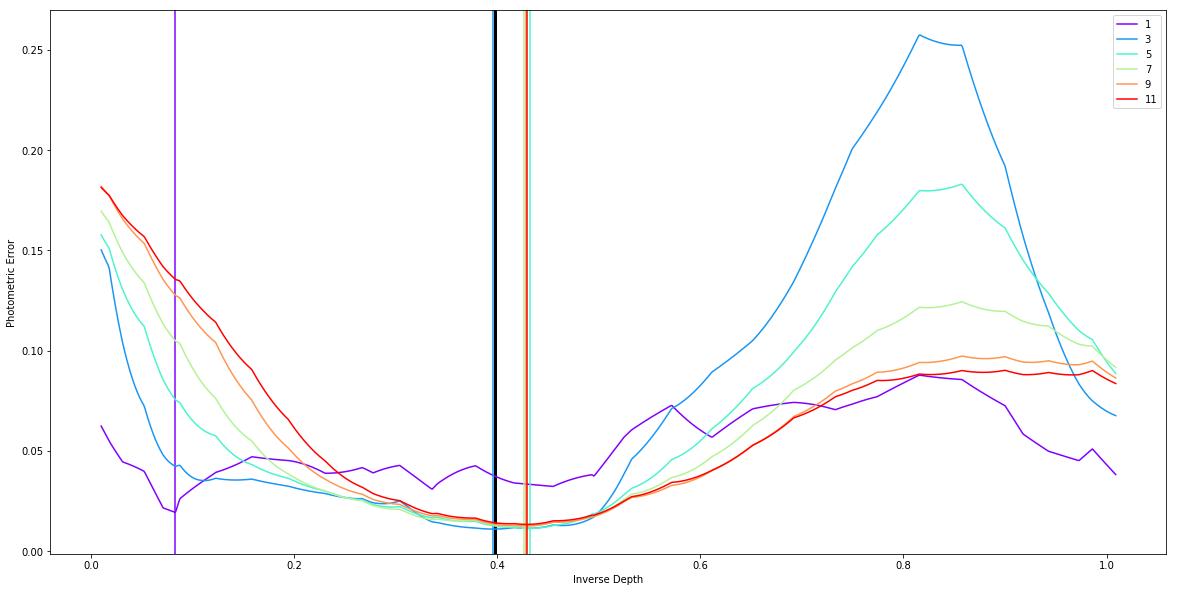

In [8]:
loss_criterion = loss_func()

result_dict = {}
for i in range(loc.shape[1]):
    result = plot_inv_curve(loc[:, i, np.newaxis],
                            loss_criterion,
                            data['tgt_RGB'],
                            data['src0_RGB'],
                            data['pose0'],
                            data['K'][:3, :3],
                            data['depth'])
    result_dict[i] = result

### Plot Curve for Patch Loss

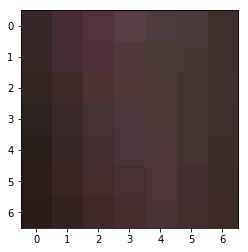

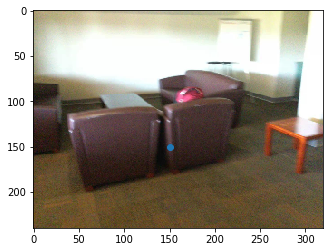

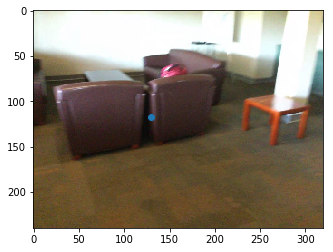

[[130.12569388 131.11560111 132.10430657 133.09181246 134.07812095
  135.06323422 136.04715444 130.1103065  131.10010241 132.08869685
  133.07609198 134.06229    135.04729307 136.03110338 130.09492287
  131.0846075  132.07309092 133.06037533 134.04646289 135.0313558
  136.01505621 130.079543   131.06911636 132.0574888  133.0446625
  134.03063964 135.0154224  135.99901295 130.06416688 131.053629
  132.04189048 133.0289535  134.01482024 134.99949288 135.98297359
  130.0487945  131.03814541 132.02629595 133.01324832 133.99900469
  134.98356723 135.96693812 130.03342588 131.02266559 132.01070522
  132.99754696 133.98319298 134.96764545 135.95090655]
 [117.17976063 117.11684906 117.05401387 116.99125491 116.92857205
  116.86596516 116.80343408 118.14893517 118.08544269 118.02202728
  117.9586888  117.89542711 117.83224207 117.76913355 119.11787334
  119.05380023 118.98980488 118.92588716 118.86204692 118.79828403
  118.73459834 120.08657521 120.02192175 119.95734676 119.89285008
  119.82843

In [18]:
def compute_homography(loc, K, pose, depth, normal):
    x, y = loc
    z, n = depth, normal
    K = K[:3, :3]
    
    R, t = pose[:3, :3], pose[:3, 3].reshape((3, 1))
    loc = to_homog(loc)
    pts_3d = np.linalg.inv(K) @ loc * z
    
    d = -n.T @ pts_3d
    H = K @ (R - np.outer(t ,(n.T / d))) @ np.linalg.inv(K)
    return H

def warp_patch_homography(pt_ctr, K, pose, depth, normal, src, patch_size=7):
    xv, yv = get_meshgrid(patch_size, patch_size, pt_ctr[0, 0], pt_ctr[1, 0]) # x-coord, y-coord
    xv = xv.flatten()
    yv = yv.flatten()
    mesh_flatten = np.vstack([xv, yv, np.ones_like(yv)]) # [3, patch_size**2]

    H = compute_homography(pt_ctr, K, pose, depth, normal)
    ps = H @ mesh_flatten
    ps = ps[:2] / (ps[2] + 1e-8)
    
    patch_img = np.zeros([patch_size, patch_size, 3])
    for x in range(patch_size):
        for y in range(patch_size):
            i = y * patch_size + x
            patch_img[y, x] = bilinear_pt(ps[:, i, np.newaxis], src)
    return ps, patch_img 

# testing the function
p = np.array([150, 150]).reshape(-1, 1)
c, img = warp_patch_homography(p, data['K'][:3, :3],
                              data['pose0'],
                              data['depth'][150, 150],
                              data['tgt_norm'][150, 150],
                              data['src0_RGB']/255)
plt.imshow(img)
plt.show()

plt.imshow(data['tgt_RGB']/255)
plt.scatter(150, 150)
plt.show()

plt.imshow(data['src0_RGB']/255)
plt.scatter(130, 117)
plt.show()
print(c)

In [19]:
def plot_patch_inv_curve(loc, loss_criterion,
                         tgt, src,
                         rel_pose, intrinsics, dmap, normal_map):
    """Plot intensity difference versus inverse depth"""
    s = 3 # rectangle size
    psize = [1, 3, 5, 7, 9, 11]
    colors = cm.rainbow(np.linspace(0, 1, loc.shape[1]))
    colors_p = cm.rainbow(np.linspace(0, 1, len(psize)))
    
    if type(tgt[0, 0, 0]) == np.uint8:
        tgt = tgt/255
    if type(src[0, 0, 0]) == np.uint8:
        src = src/255
    
    # prepare figure
    fig = plt.figure(figsize=(20, 10))
    ax_tgt = fig.add_subplot(131)
    ax_src = fig.add_subplot(132)
    ax_src_big = fig.add_subplot(133)
    ax_tgt.imshow(tgt)
    ax_src.imshow(src)
    ax_src_big.imshow(src)
    ax_tgt.set_title('Target')
    ax_src.set_title('Source')
    ax_src_big.set_title('Source Enlarged')
    ax_src.set_ylim(bottom=H, top=0)

    # warp provided coordinates
    inv_depth_values = np.arange(0.01, 1.01, 0.001)
    locations = np.split(loc, loc.shape[1], axis=1)

    # will contain tuple of ('pt', 'ps', 'It', 'Is', 'inv_depth', 'diff')
    result = defaultdict(list)
    r = namedtuple('r', 'pt ps It Is src_coords inv_depth diff')
    
    first_iter = True
    for i, (pt, c) in enumerate(zip(locations, colors)):
        print('{}/{} locations'.format(i+1, loc.shape[1]))
        x_ctr, y_ctr = pt[0, 0], pt[1, 0]
        gt_normal = normal_map[y_ctr, x_ctr]
        for patch_size in psize:
            n_mid = (patch_size**2 - 1)//2
            tgt_patch = get_tgt_patch(pt, tgt, patch_size) # single-pixel
            for inv_d in inv_depth_values:
                # warp
                d = 1/inv_d
                if patch_size == 1:
                    ps = warp_location(pt, intrinsics, rel_pose, d)
                    src_patch = bilinear_pt(ps[:, 0, np.newaxis], src) # single-pixel
                    diff = np.mean(np.abs(tgt_patch - src_patch))
                    tmp = r(pt=pt, ps=ps,
                            It=tgt_patch, Is=src_patch,
                            src_coords=None,
                            inv_depth=inv_d, diff=diff)
                else:
                    src_coords, src_patch = warp_patch_homography(
                                                pt,
                                                intrinsics,
                                                rel_pose,
                                                d, # depth
                                                gt_normal,
                                                src, patch_size)
                    ps = src_coords[:, n_mid, np.newaxis]
                    diff = loss_criterion(tgt_patch, src_patch)
                    tmp = r(pt=pt, ps=ps,
                            It=tgt_patch, Is=src_patch,
                            src_coords=src_coords,
                            inv_depth=inv_d, diff=diff)
                    
                    if first_iter:
                        first_iter = False
                        print('Src Patch (min, max)=', np.min(src_patch), np.max(src_patch))
#                         print(src_coords)
#                         fig2 = plt.figure()
#                         ax_tmp = fig2.add_subplot(111)
#                         ax_tmp.imshow(src_patch)
#                         ax_tmp.set_title('Source Patch')
#                         fig2.show()
                        
                result[(i, patch_size)].append(tmp)

    # plot RGB images for comparison
    print('Generating plots')
    for i, (pt, c) in enumerate(zip(locations, colors)):
        # plot rectangles on target image
        rect = patches.Rectangle((pt[0, 0]-s//2, pt[1, 0]-s//2), s, s,
                                 linewidth=1,edgecolor=c,facecolor='none')
        ax_tgt.add_patch(rect)

        # plot ground-truth correspondence on source image
        gt_corr = warp_location(pt, intrinsics, rel_pose, dmap[tuple(pt)[::-1]])
        rect2 = patches.Rectangle((gt_corr[0, 0]-s//2, gt_corr[1, 0]-s//2), s, s,
                                   linewidth=3,edgecolor='k',facecolor='none')
        rect2_ = patches.Rectangle((gt_corr[0, 0]-s//2, gt_corr[1, 0]-s//2), s, s,
                                   linewidth=3,edgecolor='k',facecolor='none')
        ax_src.add_patch(rect2)
        ax_src_big.add_patch(rect2_)
        ax_src_big.set_xlim([gt_corr[0, 0]-10, gt_corr[0, 0]+10])
        ax_src_big.set_ylim([gt_corr[1, 0]-10, gt_corr[1, 0]+10])

        # plot lowest photometric loss on source image
        for patch_size, c_p in zip(psize, colors_p):
            diffs = [x.diff for x in result[(i, patch_size)]]
            lowest_idx = np.argmin(diffs)
            lowest_ps = result[(i, patch_size)][lowest_idx].ps
            circle = patches.Circle((lowest_ps[0, 0], lowest_ps[1, 0]), radius=s//2,
                                     linewidth=1,edgecolor=c_p,facecolor='none')
            circle_ = patches.Circle((lowest_ps[0, 0], lowest_ps[1, 0]), radius=s//2,
                                     linewidth=1,edgecolor=c_p,facecolor='none')
            ax_src.add_patch(circle)
            ax_src_big.add_patch(circle_)
            
            if patch_size != 1:
                lowest_src_coords = result[(i, patch_size)][lowest_idx].src_coords
                sz = np.sqrt(lowest_src_coords.shape[1]).astype(int)
                coord = lowest_src_coords.reshape([2, sz, sz])
                upper_left  = coord[:, 0, 0]
                upper_right = coord[:, 0, sz-1]
                lower_left = coord[:, sz-1, 0]
                lower_right = coord[:, sz-1, sz-1]
                lines = [[upper_left, upper_right], 
                         [upper_right, lower_right],
                         [lower_right, lower_left],
                         [lower_left, upper_left]]
                lc = mc.LineCollection(lines, colors=c_p, linewidths=1)
                ax_src_big.add_collection(lc)
                    
            #plt.text(lowest_ps[0, 0], lowest_ps[1, 0]-5, '{}'.format(patch_size))
            
    plt.show()

    # plot error curve
    for i in range(loc.shape[1]):
        gt_depth = dmap[tuple(locations[i])[::-1]]
        gt_normal = normal_map[tuple(locations[i])[::-1]]
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        ax.axvline(x=1/gt_depth, c='k', linewidth=3)
        
        print(locations[i].flatten(), 'ground truth normal', ':',gt_normal)
        print(locations[i].flatten(), 'ground truth depth', ':',gt_depth[0])
        
        p_min, err_min = -1, 1e6
        for patch_size, c in zip(psize, colors_p):
            diffs = [x.diff for x in result[(i, patch_size)]]
            lowest_idx = np.argmin(diffs)
            lowest_inv_depth = result[(i, patch_size)][lowest_idx].inv_depth
            ax.plot(inv_depth_values, diffs, c=c, label=patch_size)
            ax.axvline(lowest_inv_depth, c=c)
            print('p={} line depth w/ lowest error:{}'.format(patch_size, 1/lowest_inv_depth))
            
            # keep track of lowest error
            err = np.abs(gt_depth - 1/lowest_inv_depth)
            if err < err_min:
                p_min, err_min = patch_size, err
                
        print('The most accurate patch size: {}, abs error: {}'.format(p_min, err_min))    
        #ax.set_xlim([1/gt_depth[0]-0.2, 1/gt_depth[0]+0.2])
        ax.set_xlabel('Inverse Depth')
        ax.set_ylabel('Photometric Error')
        ax.legend()
        plt.show()

    plt.close('all')
    return result

#### Choose Location

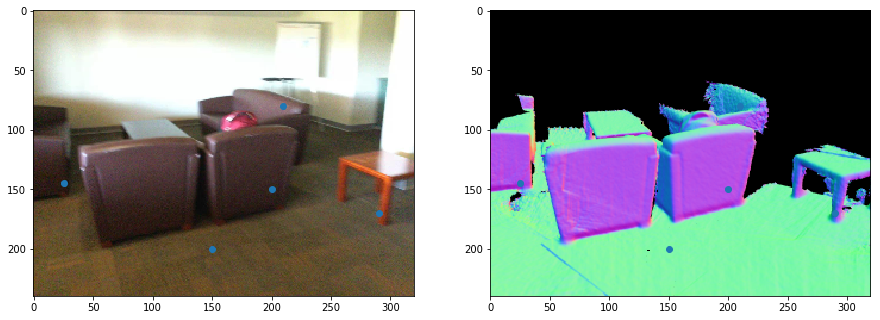

In [20]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(data['tgt_RGB'])
ax2.imshow(plot_normal(data['tgt_norm']))

ax1.scatter(loc[0, :], loc[1, :])
ax2.scatter(loc[0, :], loc[1, :])
plt.show()

#### Plot curve

1/1 locations
Src Patch (min, max)= -2.7755575615628914e-17 1.3877787807814457e-17
Generating plots


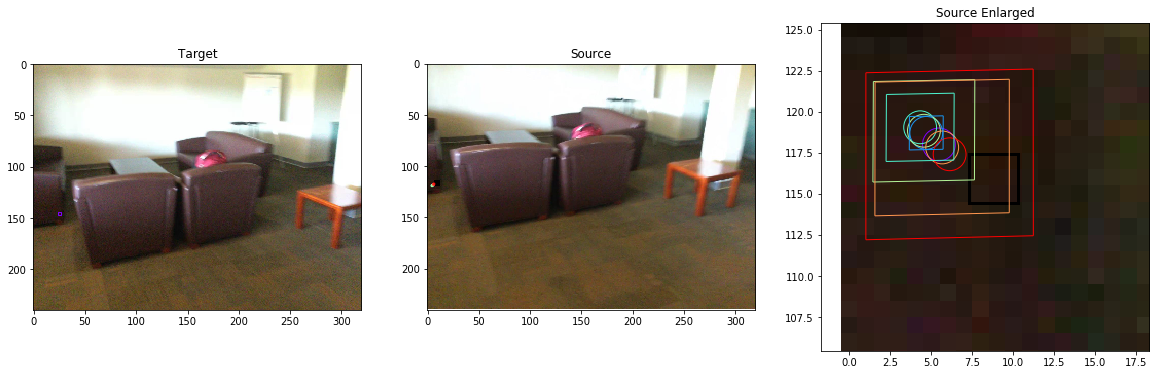

[ 25 145] ground truth normal : [[ 0.45098039  0.63921569 -0.61568627]]
[ 25 145] ground truth depth : 2.889
p=1 line depth w/ lowest error:4.065040650406507
p=3 line depth w/ lowest error:4.566210045662104
p=5 line depth w/ lowest error:4.854368932038838
p=7 line depth w/ lowest error:4.672897196261686
p=9 line depth w/ lowest error:3.9525691699604777
p=11 line depth w/ lowest error:3.7174721189591104
The most accurate patch size: 11, abs error: [0.82847212]


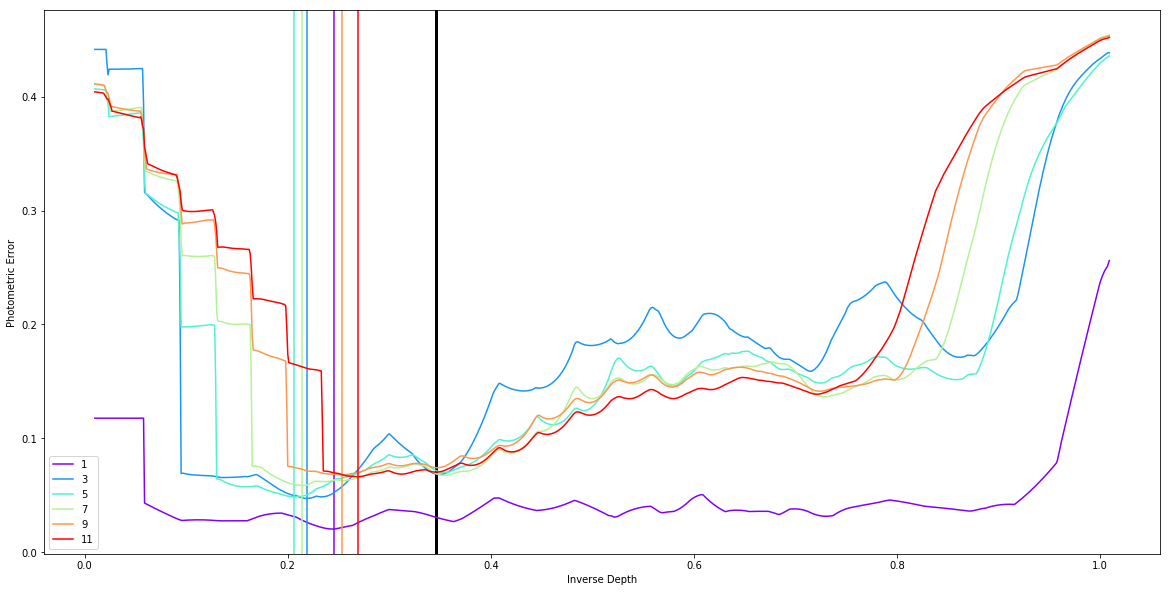

1/1 locations
Src Patch (min, max)= 0.16063799391023306 0.35989025748538916
Generating plots


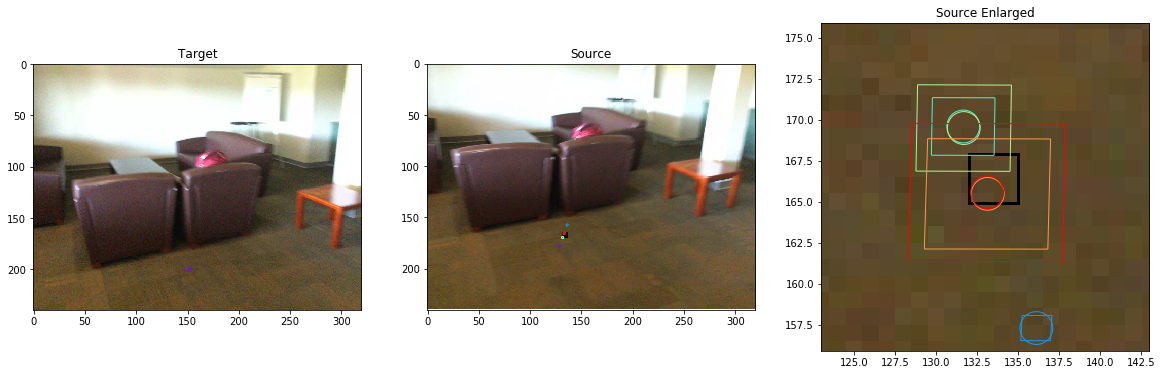

[150 200] ground truth normal : [[ 0.01176471 -0.96078431 -0.27058824]]
[150 200] ground truth depth : 2.301
p=1 line depth w/ lowest error:18.51851851851853
p=3 line depth w/ lowest error:1.3698630136986312
p=5 line depth w/ lowest error:3.1746031746031775
p=7 line depth w/ lowest error:3.1446540880503173
p=9 line depth w/ lowest error:2.2271714922049015
p=11 line depth w/ lowest error:2.242152466367715
The most accurate patch size: 11, abs error: [0.05884753]


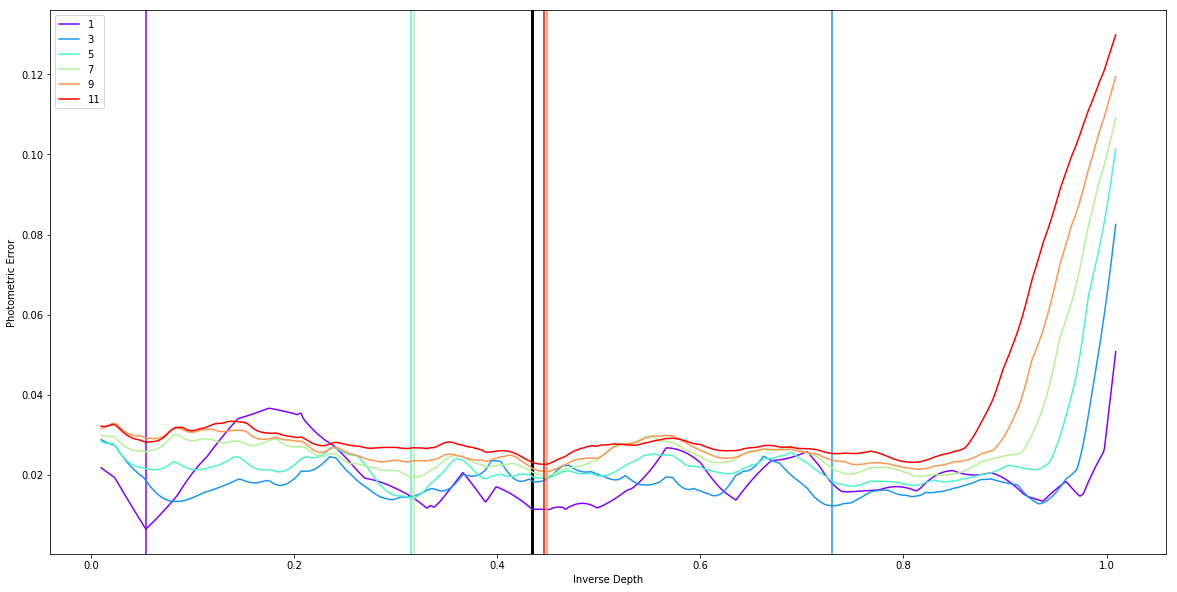

1/1 locations
Src Patch (min, max)= 0.08096947841399098 0.16551979583854404
Generating plots


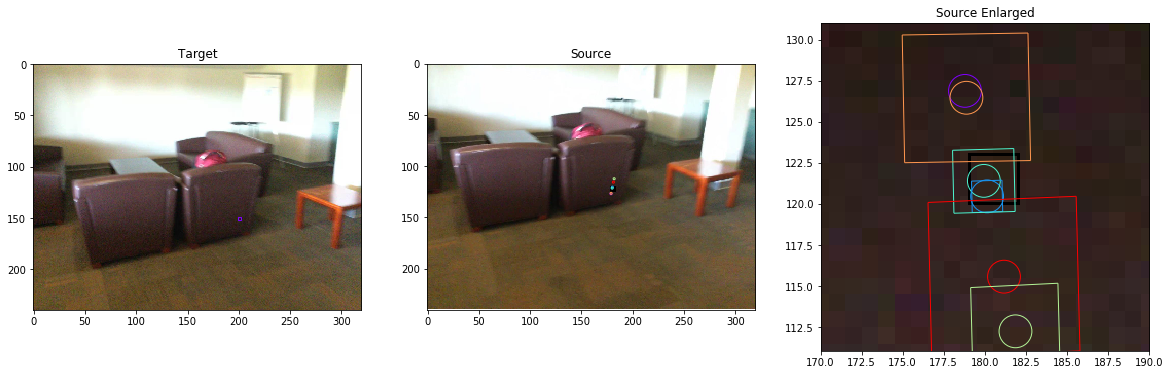

[200 150] ground truth normal : [[ 0.41960784  0.39607843 -0.81176471]]
[200 150] ground truth depth : 2.658
p=1 line depth w/ lowest error:6.756756756756762
p=3 line depth w/ lowest error:2.5000000000000018
p=5 line depth w/ lowest error:2.7624309392265216
p=7 line depth w/ lowest error:1.3386880856760386
p=9 line depth w/ lowest error:6.097560975609761
p=11 line depth w/ lowest error:1.6583747927031522
The most accurate patch size: 5, abs error: [0.10443094]


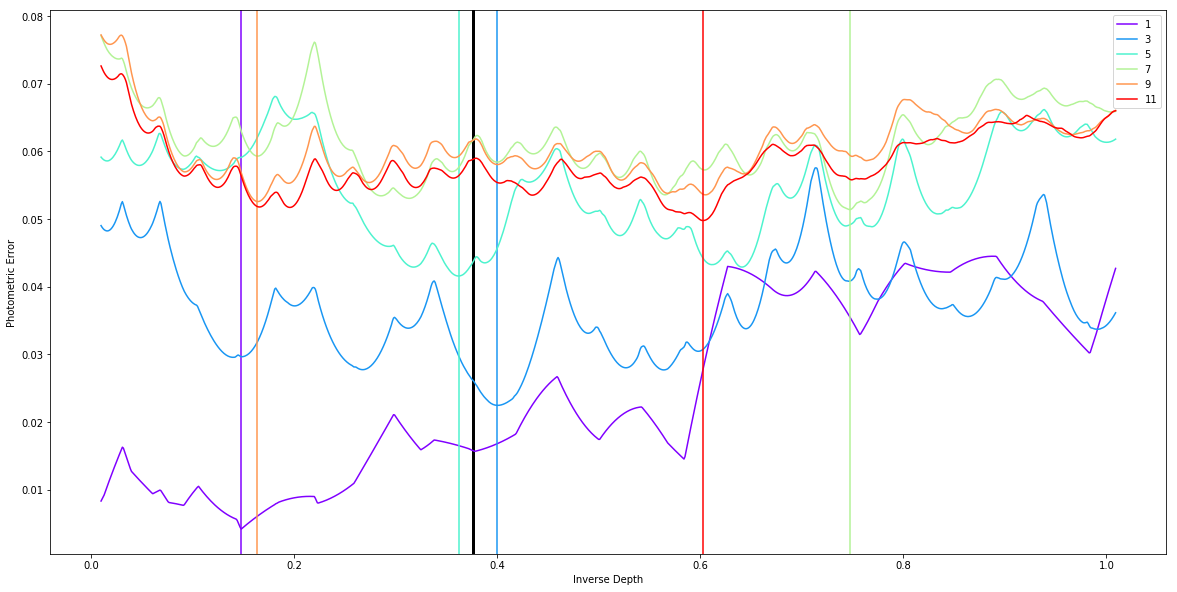

1/1 locations
Src Patch (min, max)= 0.43625507366024247 0.5748228133423592
Generating plots


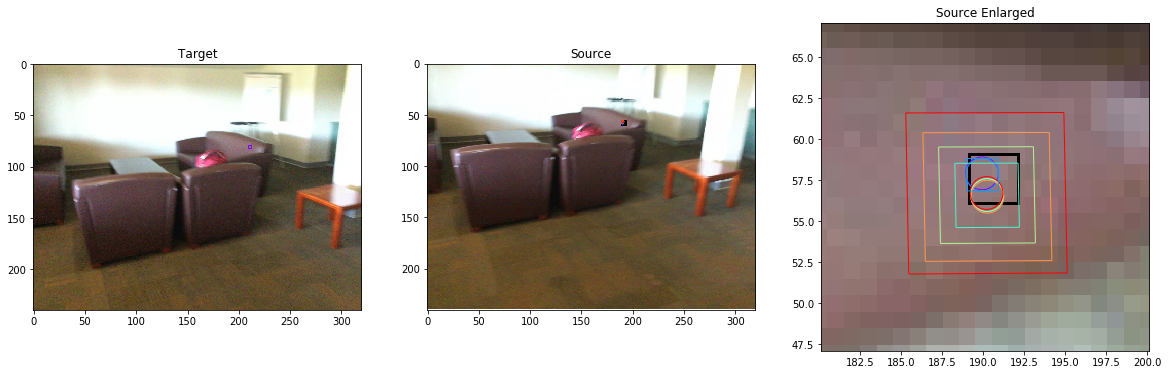

[210  80] ground truth normal : [[-0.85098039 -0.09019608 -0.51372549]]
[210  80] ground truth depth : 4.446
p=1 line depth w/ lowest error:5.586592178770954
p=3 line depth w/ lowest error:5.464480874316944
p=5 line depth w/ lowest error:3.921568627450984
p=7 line depth w/ lowest error:3.9370078740157513
p=9 line depth w/ lowest error:3.8461538461538494
p=11 line depth w/ lowest error:4.048582995951421
The most accurate patch size: 11, abs error: [0.397417]


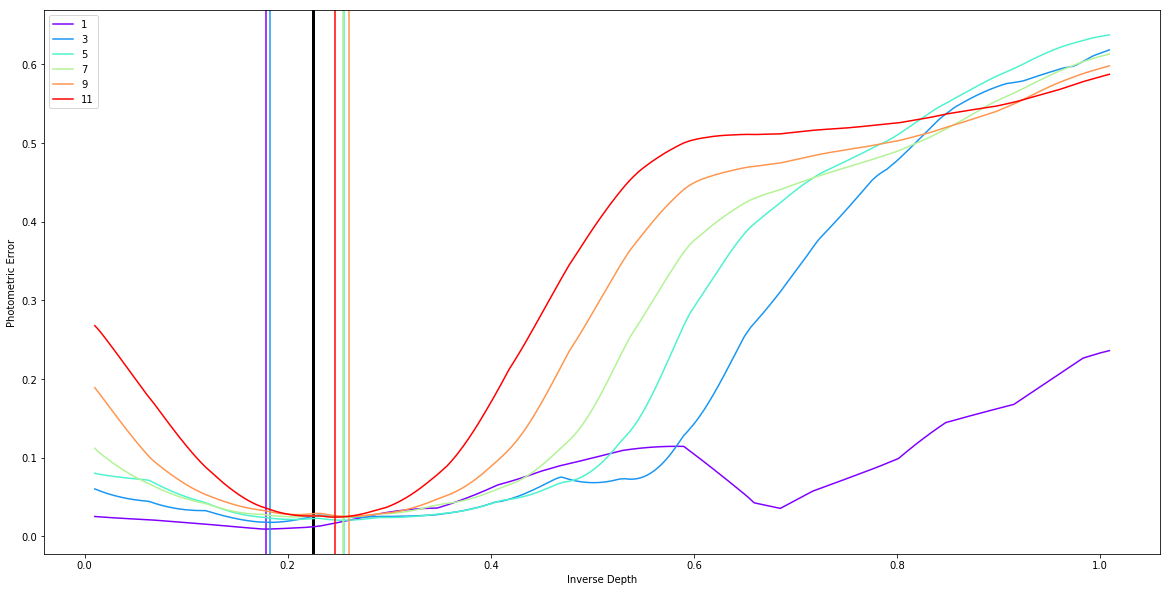

1/1 locations
Src Patch (min, max)= 0.19862507127264878 0.3977437822786564
Generating plots


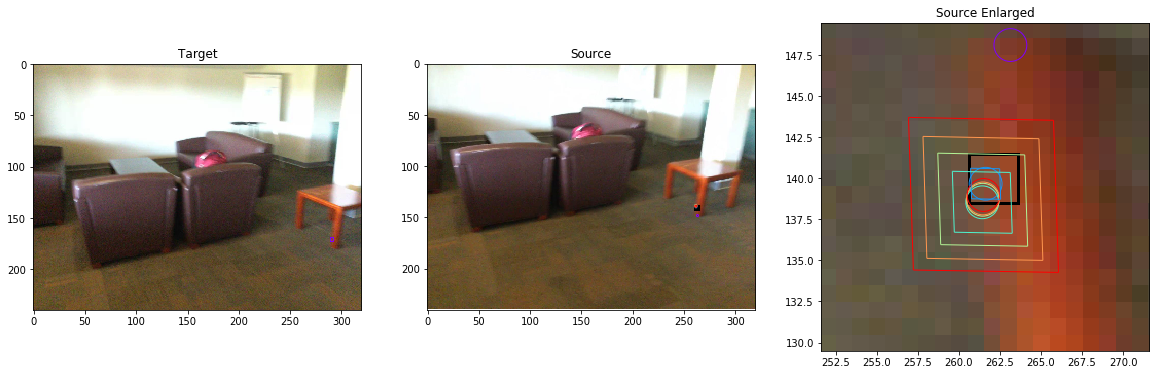

[290 170] ground truth normal : [[-0.44313725  0.46666667 -0.73333333]]
[290 170] ground truth depth : 2.514
p=1 line depth w/ lowest error:12.048192771084347
p=3 line depth w/ lowest error:2.5575447570332503
p=5 line depth w/ lowest error:2.3041474654377896
p=7 line depth w/ lowest error:2.336448598130843
p=9 line depth w/ lowest error:2.35294117647059
p=11 line depth w/ lowest error:2.398081534772184
The most accurate patch size: 3, abs error: [0.04354476]


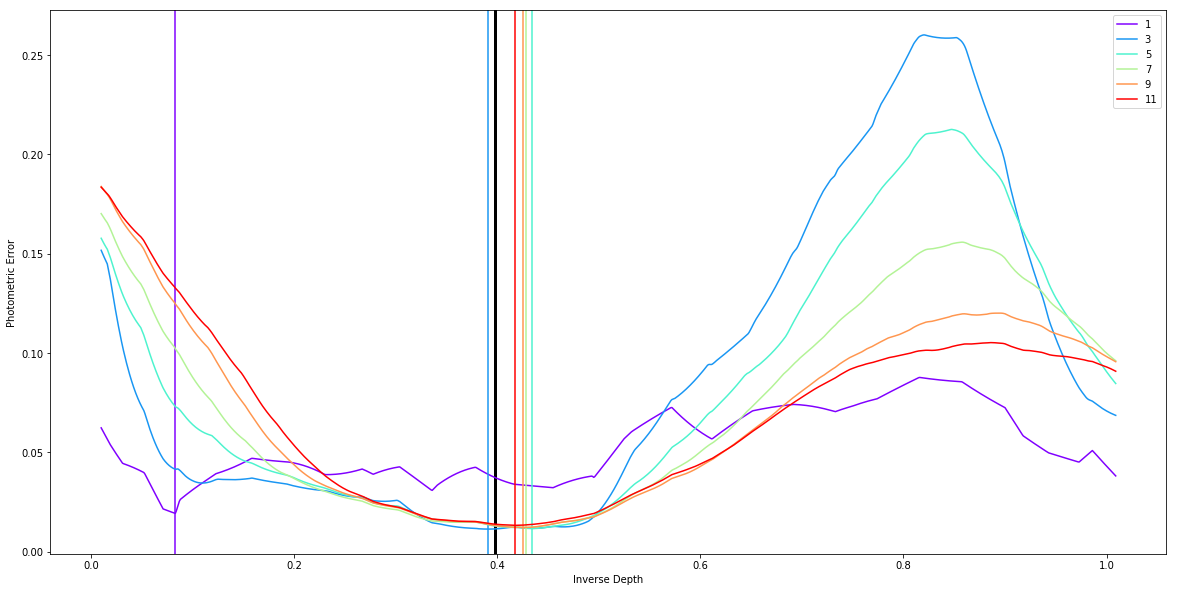

In [21]:
loss_criterion = loss_func()

patch_result_dict = {}
for i in range(loc.shape[1]):
    result = plot_patch_inv_curve(loc[:, i, np.newaxis],
                                  loss_criterion,
                                  data['tgt_RGB'],
                                  data['src0_RGB'],
                                  data['pose0'],
                                  data['K'][:3, :3],
                                  data['depth'],
                                  data['tgt_norm'])
    patch_result_dict[i] = result